# Semantic Search in Quran

In this notebook, we will explore embeddings and try them out against Quran, in the original text as well as translations.

TODO: perhaps its more efficient to take 5 verses at a time with 1 overlap and thus create fewer embeddings. 

In [23]:
pip install --quiet --upgrade chromadb tqdm numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [6]:
import chromadb
client = chromadb.PersistentClient(path='./chroma')

In [13]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from tqdm import tqdm

embedding_function = SentenceTransformerEmbeddingFunction()

def genEmbeddings(ayats):
    embeddings = [ embedding_function(x)[0] for x in tqdm(ayats)]
    return embeddings

/home/qasim/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
def getSplits(data):
    splits = data[0].page_content.split('\n')
    splits = splits[0:6235]
    ids = [ str(idx) + ':' + ':'.join(x.split('|')[0:2]) for idx,x in enumerate(splits)]
    ayats = [ x.split('|')[2:] for x in splits]
    return splits, ids, ayats

## Urdu

We will use tanzil.net translation for Urdu

In [5]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://tanzil.net/trans/ur.jawadi")
data = loader.load()

print(len(data))

1


In [27]:
splits, ids, ayats = getSplits(data)
print(len(ids))


6235


In [17]:


col = client.get_collection('quran-urdu')
if col == None:
    col = client.create_collection('quran-urdu',embedding_function=embedding_function)
    embeddings = genEmbeddings(ayats)
    col.add(ids,embeddings=embeddings)
col.count()

6235

In [15]:
import pandas as pd
query = ayats[0]
results = col.query(query_embeddings = embedding_function(query)[0],n_results=5)
df = pd.DataFrame({ 'Verse': [splits[int(x.split(':')[0])] for x in results['ids'][0]], 'Distance' :[ x for x in results['distances'][0] ]})
print(query[0])
df.head()

عظیم اور دائمی رحمتوں والے خدا کے نام سے


,Verse,Distance
0,1|1|عظیم اور دائمی رحمتوں والے خدا کے نام سے,0.000000
1,81|17|اور رات کی قسم جب ختم ہونے کو آئے,0.237556
2,106|4|جس نے انہیں بھوک میں سیر کیا ہے اور خوف ...,0.276885
3,70|34|اور جو اپنی نمازوں کا خیال رکھنے والے ہیں,0.302487
4,37|115|اور انہیں اور ان کی قوم کو عظیم کرب سے ...,0.313914


## English

Now let's repeat the same excercise for MH Shakir's translation in English

In [7]:
from langchain.document_loaders import WebBaseLoader
loader = WebBaseLoader("https://tanzil.net/trans/en.shakir")
en_data = loader.load()

print(len(en_data))

1


In [11]:
en_splits, en_ids, en_verses = getSplits(en_data)
print(len(en_splits))
print(en_splits[1])

6235
1|2|All praise is due to Allah, the Lord of the Worlds.


In [14]:
try:
    col = client.get_collection('quran-english')
except ValueError:
    col = client.create_collection('quran-english',embedding_function=embedding_function)
    embeddings = genEmbeddings(en_verses)
    col.add(en_ids,embeddings=embeddings)

col.count()

100%|███████████████████████████████████████| 6235/6235 [01:54<00:00, 54.26it/s]


6235

In [15]:
import pandas as pd
query = en_verses[0]
results = col.query(query_embeddings = embedding_function(query)[0],n_results=5)
df = pd.DataFrame({ 'Verse': [en_splits[int(x.split(':')[0])] for x in results['ids'][0]], 'Distance' :[ x for x in results['distances'][0] ]})
print(query[0])
df.head()

In the name of Allah, the Beneficent, the Merciful.


,Verse,Distance
0,"1|1|In the name of Allah, the Beneficent, the ...",0.000000
1,"41|2|A revelation from the Beneficent, the Mer...",0.270988
2,"55|1|The Beneficent Allah,",0.340093
3,"1|3|The Beneficent, the Merciful.",0.470140
4,30|5|With the help of Allah; He helps whom He ...,0.552459


As we can see -the quality of embeddings search is dependent on the language, and we get much better results in English

## Visualization

Here we use umap to visualize how the search has been working for us

In [16]:
col = client.get_collection('quran-english')
embeddings = col.get(include=['embeddings'])['embeddings']
print(len(embeddings))

6235


In [32]:
pip install --quiet umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [35]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

reducer = umap.UMAP(random_state=0,transform_seed=0)
umap_transform = reducer.fit(embeddings)

/home/qasim/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [46]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i,embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


In [47]:
projected_en_embeddings = project_embeddings(embeddings,umap_transform)

  0%|                                                  | 0/6235 [00:00<?, ?it/s]/home/qasim/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|█████████████████████████████████████| 6235/6235 [1:09:33<00:00,  1.49it/s]


In [54]:
query = en_verses[0]
query_embeddings = embedding_function(query)[0]
results = col.query(query_embeddings = query_embeddings, n_results=5, include=['documents','embeddings'])
retrieved_embeddings = results['embeddings'][0]
projected_query_embeddings = project_embeddings([query_embeddings],umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings,umap_transform)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


(-10.22195258140564,
 18.251540327072142,
 -4.504253184795379,
 14.204211270809173)

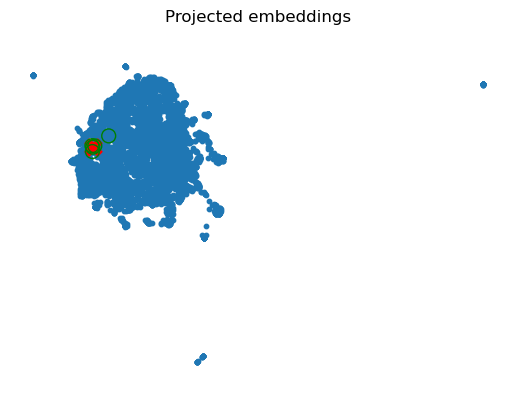

In [55]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_en_embeddings[:,0],projected_en_embeddings[:,1], s=10)
plt.scatter(projected_query_embeddings[:,0],projected_query_embeddings[:,1], s=150,marker='X',color='r')
plt.scatter(projected_retrieved_embeddings[:,0],projected_retrieved_embeddings[:,1], s=100, facecolors='none',edgecolors='g')

plt.gca().set_aspect('equal','datalim')
plt.title('Projected embeddings')
plt.axis('off')
